In [1]:
import glob; import sys; import os
import pandas as pd
import functions
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
from matplotlib.lines import Line2D
from math import ceil
from matplotlib.legend import Legend


pd.options.mode.chained_assignment = None
plt.rcParams.update({'font.size': 20}) # Set a good font size

# Defining constants
G = 1.908e5 # R_sol*(M_sol)^-1*km^2*s^-2 
pc2AU = 206265 # Pc -> AU
Rsol2AU = 0.00465047 # Rsol -> AU
pcMyr2kms = 1.023 # Pc/Myr -> km/s
Myr2s = 3600*24*265.25 * 1e6
c = 3e5 # km/s

In [2]:
dataDir = functions.get_Started()

Possible Directories:

0 : COMPAS_Output_1%sol_fallback
1 : COMPAS_Output_1%sol_noKicks
2 : COMPAS_Output_1%sol_reduced
3 : COMPAS_Output_1%_correctedEVO
4 : COMPAS_Output_1%_no_CHE
5 : COMPAS_Output_1%_pessCHE
6 : COMPAS_Output_largea_detailed
7 : COMPAS_Output_largea_detailed2
8 : COMPAS_Output_noBHKick_Z0.0001
9 : COMPAS_Output_noBHKick_Z0.001
10 : COMPAS_Output_noChem
11 : COMPAS_Output_PeTar_M100000
12 : COMPAS_Output_smalla_detailed
13 : COMPAS_Output_smalla_detailed2
14 : COMPAS_Output_sol_correctEVO
15 : COMPAS_Output_sol_no_CHE
16 : COMPAS_Output_SSE_Z0.00015
17 : COMPAS_Output_SSE_Z0.0015
18 : COMPAS_Output_test
19 : COMPAS_Output_test2
20 : COMPAS_Output_Z0.0001
21 : COMPAS_Output_Z0.00015
22 : COMPAS_Output_Z0.0005
23 : COMPAS_Output_Z0.00075
24 : COMPAS_Output_Z0.001
25 : COMPAS_Output_Z0.0015
26 : COMPAS_Output_Z0.005
27 : COMPAS_Output_Z0.0075
28 : COMPAS_Output_Z0.01
29 : COMPAS_Output_Z0.01_varied



What directory is the data stored in?    20


In [3]:
# Load in the double compact objects as well as the system parameters
DCO = pd.read_csv(os.path.join(dataDir, 'BSE_Double_Compact_Objects.csv'), skiprows=2)
SP = pd.read_csv(os.path.join(dataDir, 'BSE_System_Parameters.csv'), skiprows=2)
SN = pd.read_csv(os.path.join(dataDir, 'BSE_Supernovae.csv'), skiprows=2)


# Find the equilibrated at birth and remove them from the DCOs
EAB = SP.loc[SP['Equilibrated_At_Birth']==1] 
DCO.drop(DCO.loc[DCO['    SEED    '].isin(EAB['    SEED    '])].index, inplace=True)
SN.drop(SN.loc[SN['    SEED    '].isin(EAB['    SEED    '])].index, inplace=True)


# Specifically grab the BBHs
BBHMaster = DCO.loc[(DCO['Stellar_Type(1)']==14)&(DCO['Stellar_Type(2)']==14)].copy()
BBHMaster.reset_index(inplace=True, drop=True)


# For now I am dropping any binaries with a>1e6
BBHMaster = BBHMaster.loc[BBHMaster['SemiMajorAxis@DCO']<1e6]

In [4]:
'''
Here we find all of the possible BH systems so that we can 
later find which have been retained.
'''

# Index for both SNs , only first and only last
SNDupIndex = SN.duplicated(subset='    SEED    ', keep=False)

SN1st = SN.loc[SN.duplicated(subset='    SEED    ', keep='last')]
SN2nd = SN.loc[SN.duplicated(subset='    SEED    ', keep='first')]

SN1st.reset_index(drop=True, inplace=True)
SN2nd.reset_index(drop=True, inplace=True)

# Two SNs
SNDup = SN.loc[SNDupIndex]
SNDup.reset_index(inplace=True, drop=True)

# Single SN
SNSing = SN.loc[~SNDupIndex]
SNSing.reset_index(inplace=True, drop=True)

# BH other star unbound and bound
BHSingUnbound = SNSing.loc[(SNSing['Stellar_Type(SN)']==14)&(SNSing['Unbound']==1)]
BHSingBound = SNSing.loc[(SNSing['Stellar_Type(SN)']==14)&(SNSing['Unbound']==0)]

BHSingUnbound.reset_index(inplace=True, drop=True)
BHSingBound.reset_index(inplace=True, drop=True)

# BBHs that remain bound
BBHBound = SN.loc[(SN['Stellar_Type(SN)']==14)&(SN['Stellar_Type(CP)']==14)&(SN['Unbound']==0)]
BBHBound.reset_index(inplace=True, drop=True)

# BH other SN
BHElse = SN2nd.loc[((SN2nd['Stellar_Type(SN)']==14)&(SN2nd['Stellar_Type(CP)']!=14))|((SN2nd['Stellar_Type(CP)']==14)&(SN2nd['Stellar_Type(SN)']!=14))]
BHElse.reset_index(drop=True, inplace=True)

# BBHs that are not bound
BBHUnbound = SN.loc[(SN['Stellar_Type(SN)']==14)&(SN['Stellar_Type(CP)']==14)&(SN['Unbound']==1)]
BBHUnbound.reset_index(inplace=True, drop=True)

# Finding the average BH mass
avgBHMass = np.mean(SN['   Mass(SN)   '].loc[SN['Stellar_Type(SN)']==14].values)  

In [5]:
# Finding the average BH mass
avgBHMass = np.mean(SN['   Mass(SN)   '].loc[SN['Stellar_Type(SN)']==14].values)  

# Set esc vel to find vel disp
vesc_array = np.logspace(0, np.log10(2e3), 100) # km/s

probOfInt = []

count=0
for vesc in vesc_array:
    # Cluster velocity dispersion
    sigmaCL = vesc/(np.sqrt(14*(1+1/avgBHMass))) # km/s
    sigmaREL = np.sqrt(2/avgBHMass) * sigmaCL

    # seeds retained from first SN
    retainedInFirst = SN1st.loc[(SN1st['SystemicSpeed ']<vesc)&(SN1st['Unbound']==0)]
    retainedSN = SN1st.loc[(SN1st['ComponentSpeed(SN)']<vesc)&(SN1st['Unbound']==1)]
    retainedCP = SN1st.loc[(SN1st['ComponentSpeed(CP)']<vesc)&(SN1st['Unbound']==1)]

    # BBHbound retained after second
    index = BBHBound['    SEED    '].isin(retainedInFirst['    SEED    '])
    BBHRetain = BBHBound.loc[(BBHBound['SystemicSpeed ']<vesc)&(index)]


    # Check if there are any duplicates
    if len(BBHRetain)!=len(np.unique(BBHRetain['    SEED    '].values)):
        BBHRetain.drop_duplicates(subset='    SEED    ', inplace=True, keep='last')

    BBHRetain.reset_index(inplace=True, drop=True)    
    '''
    Finding hard binaries
    '''
    # Reduced Mass
    mu  = BBHRetain['   Mass(SN)   ']*BBHRetain['   Mass(CP)   ']/(BBHRetain['   Mass(SN)   ']+BBHRetain['   Mass(CP)   '])

    # calculate hard boundary
    ah  = (G * mu)/sigmaREL**2 # Rsol

    BBHRetain['ah'] = ah

    # Define the hard index
    hard = BBHRetain['SemiMajorAxis '] < BBHRetain['ah']

    # Define binary total mass
    Mtot = BBHRetain['   Mass(SN)   '] + BBHRetain['   Mass(CP)   ']
    BBHRetain['Mtot'] = Mtot

    '''
    Finding all of the retained singles (we only need to know the masses)
    '''
    singlesMass = np.array([])
    # BBHUnbound on second
    index = BBHUnbound['    SEED    '].isin(retainedInFirst['    SEED    '])

    singlesMass = np.append(singlesMass, BBHUnbound['   Mass(SN)   '].loc[(index)&(BBHUnbound['ComponentSpeed(SN)']<vesc)].values)
    singlesMass = np.append(singlesMass, BBHUnbound['   Mass(CP)   '].loc[(index)&(BBHUnbound['ComponentSpeed(CP)']<vesc)].values)
    singlesMass = np.append(singlesMass, retainedSN['   Mass(SN)   '].loc[retainedSN['Stellar_Type(SN)']==14].values)

    index = SN2nd['    SEED    '].isin(retainedCP['    SEED    '])
    singlesMass = np.append(singlesMass, SN2nd['   Mass(SN)   '].loc[(index)&(SN2nd['ComponentSpeed(SN)']<vesc)&(SN2nd['Stellar_Type(SN)']==14)].values)

    # Average Masses
    singleMassMu = np.mean(singlesMass)
    BBHMassMu = np.mean(BBHRetain['   Mass(CP)   '].values+BBHRetain['   Mass(SN)   '].values)

    k = 2 # Parameter for setting the interaction rate

    # Only take hard binaries
    BBHRetainHard = BBHRetain.loc[hard]
    BBHRetainHard.reset_index(inplace=True, drop=True)

    # Define projectile binaries
    proj = BBHRetainHard

    # Pick properties of the target binary
    mass_target = BBHMassMu # Msol
    a_target = 1/Rsol2AU # Rsol

    # Calculating the relative velocity dispersions 
    # Relative vel disp for single projectiles
    sigmaRelSingle = sigmaCL * np.sqrt(1/avgBHMass + singleMassMu/(avgBHMass*mass_target))
    # Relative vel disp for BBH projectiles
    sigmaRelBBH = sigmaCL * np.sqrt(1/avgBHMass + BBHMassMu/(avgBHMass*mass_target))

    # Calculate aej for target binary assuming mean single mass and equal mass binary target
    aej = 0.2 * G/vesc**2 * (mass_target/2)**2 / (mass_target + singleMassMu) # Rsol
    
    # Number of interactions to reach aej
    n = ceil(np.log10(a_target/aej)/np.log10(1.2))

    # List to store the probabilities at each interactions
    probs = np.array([])
    for intNum in range(n+1):
        # Interaction of target binary with singles
        gammaS = np.sum(a_target**2 *sigmaRelSingle* (1 + (G*(mass_target+singlesMass))/(k*a_target*sigmaRelSingle**2)))
        # Interaction of target binary with other binaries
        gammaB = np.sum((a_target + proj['SemiMajorAxis '].values)**2 *sigmaRelBBH* (1 + (G*(mass_target+proj['Mtot'].values))/(k*(a_target + proj['SemiMajorAxis '].values)*sigmaRelBBH**2)))

        probs = np.append(probs, gammaS/(gammaS+gammaB))

        # Update the target semi-major axis
        a_target = a_target/1.2

    probOfInt.append(1 - np.prod(probs))
    
    count+=1
    print(f'{count/len(vesc_array):.0%} Completed', end='\r')

probOfInt = np.asarray(probOfInt)
    

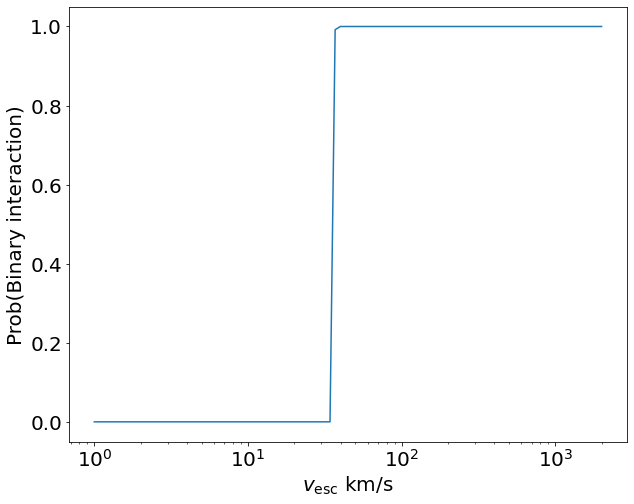

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(vesc_array, probOfInt)

ax.set_xlabel('$v_{\mathrm{esc}}$ km/s')
ax.set_ylabel('Prob(Binary interaction)')
ax.set_xscale('log')

In [7]:
n

44

Completed a=0.01ah
Completed a=0.1ah
Completed a=1.0ah
Completed a=0.01ah
Completed a=0.1ah
Completed a=1.0ah


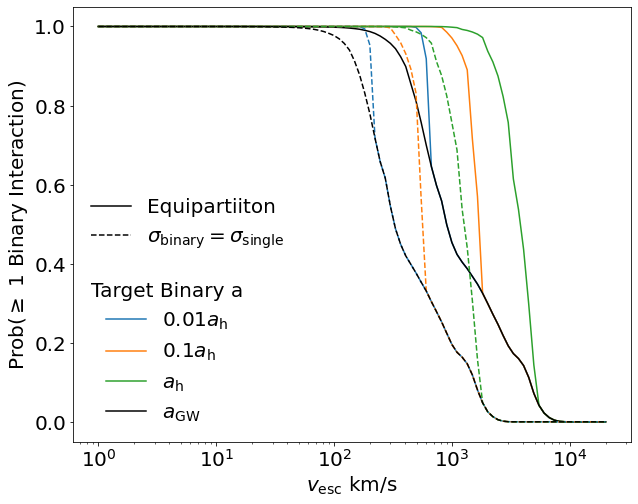

In [13]:
# Define density of the cluster to determine aGW
rho = 1e6 # Msol/pc^3

# For a binary with average eccentricity 2/3 ~ 0.1 Timescale
e = 0 

# Equipartition parameter 
eta = 1

# To set the system in equilibrium (BHs have same velocity dispersion as stars) set eta=avgBHMass/avgStarMAss
# eta = avgBHMass/1

# if e==2/3:
#     tcut*=0.1

# Fraction of energy taken in a single interaction
delta=0.2

vesc_array = np.logspace(0, np.log10(2e4), 100) # km/s

fig, ax = plt.subplots(figsize=(10,8))

ahFrac = np.array([0.01,0.1,1]) 
ls=['-','--']
lcount=0
for eta in [1, avgBHMass]:
    for j in ahFrac:
        probOfInt = []
        numOfInt = []
        count=0

        probIntGW = []
        probIntaej = []

        agwarray=[]
        aejarray=[]
        Ns=[]
        Nb=[]
        massRatio=[]
        avgsemi=[]

        for vesc in vesc_array:
            # Cluster velocity dispersion
            sigmaCL = vesc/(np.sqrt(14*(1+eta/avgBHMass))) # km/s
            sigmaREL = np.sqrt((eta)/avgBHMass) * sigmaCL

            # seeds retained from first SN
            retainedInFirst = SN1st.loc[(SN1st['SystemicSpeed ']<vesc)&(SN1st['Unbound']==0)]
            retainedSN = SN1st.loc[(SN1st['ComponentSpeed(SN)']<vesc)&(SN1st['Unbound']==1)]
            retainedCP = SN1st.loc[(SN1st['ComponentSpeed(CP)']<vesc)&(SN1st['Unbound']==1)]

            # BBHbound retained after second
            index = BBHBound['    SEED    '].isin(retainedInFirst['    SEED    '])
            BBHRetain = BBHBound.loc[(BBHBound['SystemicSpeed ']<vesc)&(index)]


            # Check if there are any duplicates
            if len(BBHRetain)!=len(np.unique(BBHRetain['    SEED    '].values)):
                BBHRetain.drop_duplicates(subset='    SEED    ', inplace=True, keep='last')

            BBHRetain.reset_index(inplace=True, drop=True)    
            '''
            Finding hard binaries
            '''
            # Reduced Mass
            mu  = BBHRetain['   Mass(SN)   ']*BBHRetain['   Mass(CP)   ']/(BBHRetain['   Mass(SN)   ']+BBHRetain['   Mass(CP)   '])

            # calculate hard boundary
            ah  = (G * mu)/sigmaREL**2 # Rsol


            BBHRetain['ah'] = ah

            # Define the hard index
            hard = BBHRetain['SemiMajorAxis '] < BBHRetain['ah']

            # Define binary total mass
            Mtot = BBHRetain['   Mass(SN)   '] + BBHRetain['   Mass(CP)   ']
            BBHRetain['Mtot'] = Mtot

            '''
            Finding all of the retained singles (we only need to know the masses)
            '''
            singlesMass = np.array([])
            # BBHUnbound on second
            index = BBHUnbound['    SEED    '].isin(retainedInFirst['    SEED    '])

            singlesMass = np.append(singlesMass, BBHUnbound['   Mass(SN)   '].loc[(index)&(BBHUnbound['ComponentSpeed(SN)']<vesc)].values)
            singlesMass = np.append(singlesMass, BBHUnbound['   Mass(CP)   '].loc[(index)&(BBHUnbound['ComponentSpeed(CP)']<vesc)].values)
            singlesMass = np.append(singlesMass, retainedSN['   Mass(SN)   '].loc[retainedSN['Stellar_Type(SN)']==14].values)

            index = SN2nd['    SEED    '].isin(retainedCP['    SEED    '])
            singlesMass = np.append(singlesMass, SN2nd['   Mass(SN)   '].loc[(index)&(SN2nd['ComponentSpeed(SN)']<vesc)&(SN2nd['Stellar_Type(SN)']==14)].values)

            # Average Masses
            if len(singlesMass)==0:
                singleMassMu=0
            else:
                singleMassMu = np.mean(singlesMass)

            BBHMassMu = np.mean(BBHRetain['   Mass(CP)   '].values+BBHRetain['   Mass(SN)   '].values)

            k = 2 # Parameter for setting the interaction rate

            # Only take hard binaries
            BBHRetainHard = BBHRetain.loc[hard]
            BBHRetainHard.reset_index(inplace=True, drop=True)

            # How many hard BBHs are ejected
            ahtot = G*(BBHBound['   Mass(SN)   ']*BBHBound['   Mass(CP)   ']/(BBHBound['   Mass(SN)   ']+BBHBound['   Mass(CP)   ']))/sigmaREL**2
            BBHEjectHard = BBHBound.loc[(BBHBound['SemiMajorAxis ']<=ahtot)&(BBHBound['SystemicSpeed ']>=vesc)]

            # Define projectile binaries
            proj = BBHRetainHard

            # Pick properties of the target binary
            mass_target = BBHMassMu # Msol

            # ah for the target binary
            ahTarg = G * (mass_target/2)**2/(mass_target*sigmaREL**2)

            a_target = j*ahTarg # Rsol

            # Calculating the relative velocity dispersions 
            # Relative vel disp for single projectiles
            sigmaRelSingle = sigmaCL * np.sqrt((eta/avgBHMass)*(1 + singleMassMu/mass_target))
            # Relative vel disp for BBH projectiles
            sigmaRelBBH = sigmaCL * np.sqrt((eta/avgBHMass)*(1 + BBHMassMu/mass_target))

            # Calculate aej for target binary assuming mean single mass and equal mass binary target
            aej = delta * G/vesc**2 * (mass_target/2)**2 / (mass_target + singleMassMu) # Rsol  

            aGW = 0.05 * (mass_target/20)**(3/5) * 0.25**(1/5) * (sigmaREL/30)**(1/5) * (1e6/rho)**(1/5) / Rsol2AU # Rsol

            maxa = max(aej, aGW)

            # Interactions at a = aGW
            gsGW = np.sum(aGW**2 *sigmaRelSingle* (1 + (G*(mass_target+singlesMass))/(k*aGW*sigmaRelSingle**2)))
            gbGW = np.sum((aGW + proj['SemiMajorAxis '].values)**2 *sigmaRelBBH* (1 + (G*(mass_target+proj['Mtot'].values))/(k*(aGW + proj['SemiMajorAxis '].values)*sigmaRelBBH**2)))

            # Interactions at a = aej
            gsej = np.sum(aej**2 *sigmaRelSingle* (1 + (G*(mass_target+singlesMass))/(k*aej*sigmaRelSingle**2)))
            gbej = np.sum((aej + proj['SemiMajorAxis '].values)**2 *sigmaRelBBH* (1 + (G*(mass_target+proj['Mtot'].values))/(k*(aej + proj['SemiMajorAxis '].values)*sigmaRelBBH**2)))

            probIntGW.append(gbGW/(gbGW+gsGW))
            probIntaej.append(gbej/(gbej+gsej)) 

    #         print(gbGW/(gsGW+gbGW))


            agwarray.append(aGW)
            aejarray.append(aej)

            avgsemi.append(np.mean(proj['SemiMajorAxis ']))
            massRatio.append((mass_target+singleMassMu)/(mass_target+BBHMassMu))

            Ns.append(len(singlesMass))
            Nb.append(len(BBHRetainHard))

    #         print(1/(1+aej/(aej+np.mean(BBHRetainHard['SemiMajorAxis ']))*len(singlesMass)/len(BBHRetainHard)))
            # Number of interactions to reach aej
            n = ceil(np.log10(a_target/maxa)/np.log10(1+delta))
            numOfInt.append(n)

            # List to store the probabilities at each interactions
            probs = np.array([])

            if n>0:
                # Takes more than 1 or more interactions to reach aej
                for intNum in range(n+1):
                    # Interaction of target binary with singles
                    gammaS = np.sum(a_target**2 *sigmaRelSingle* (1 + (G*(mass_target+singlesMass))/(k*a_target*sigmaRelSingle**2)))
                    # Interaction of target binary with other binaries
                    gammaB = np.sum((a_target + proj['SemiMajorAxis '].values)**2 *sigmaRelBBH* (1 + (G*(mass_target+proj['Mtot'].values))/(k*(a_target + proj['SemiMajorAxis '].values)*sigmaRelBBH**2)))

                    probs = np.append(probs, gammaS/(gammaS+gammaB))

                    # Update the target semi-major axis
                    a_target = a_target/(1+delta)

                probOfInt.append(1 - np.prod(probs))

            elif (n<=0)&(maxa==aej):
                print('a is less than aej')
                # Already at aej or below aej and so 1 interaction ejects
                # Interaction of target binary with singles
                gammaS = np.sum(a_target**2 *sigmaRelSingle* (1 + (G*(mass_target+singlesMass))/(k*a_target*sigmaRelSingle**2)))
                # Interaction of target binary with other binaries
                gammaB = np.sum((a_target + proj['SemiMajorAxis '].values)**2 *sigmaRelBBH* (1 + (G*(mass_target+proj['Mtot'].values))/(k*(a_target + proj['SemiMajorAxis '].values)*sigmaRelBBH**2)))

                # Calculate the probability of single interaction and the inverse it to find the probability of a binary interaction
                probs = gammaS/(gammaS+gammaB)
                probOfInt.append(1 - probs)

            elif (n<=0)&(maxa==aGW):
    #             probOfInt.append(0)
                a_target = maxa
                # Already at aGW or below aGW and so only experience 1 interaction then likely merge
                # Interaction of target binary with singles
                gammaS = np.sum(a_target**2 *sigmaRelSingle* (1 + (G*(mass_target+singlesMass))/(k*a_target*sigmaRelSingle**2)))
                # Interaction of target binary with other binaries
                gammaB = np.sum((a_target + proj['SemiMajorAxis '].values)**2 *sigmaRelBBH* (1 + (G*(mass_target+proj['Mtot'].values))/(k*(a_target + proj['SemiMajorAxis '].values)*sigmaRelBBH**2)))

                # Calculate the probability of single interaction and the inverse it to find the probability of a binary interaction
                probs = gammaS/(gammaS+gammaB)
                probOfInt.append(1 - probs)

            count+=1
            print(f'{count/len(vesc_array):.0%} Completed', end='\r')


        probOfInt = np.asarray(probOfInt)

        probIntGW = np.asarray(probIntGW)
        probIntaej = np.asarray(probIntaej)
        Ns = np.asarray(Ns)
        Nb = np.asarray(Nb)
        massRatio = np.asarray(massRatio)
        avgsemi = np.asarray(avgsemi)
        print(f'Completed a={j}ah')
        ax.plot(vesc_array, probOfInt, linestyle=ls[lcount], label=f'a={j}$a_{{h}}$')

    
    # ax.plot(vesc_array, agwarray, color='black', linestyle=':')
    # ax.plot(vesc_array, aejarray, color='tab:purple', linestyle=':')
    ax.plot(vesc_array, probIntGW, color='black', linestyle=ls[lcount], label='a=$a_{\mathrm{GW}}$')
    # ax.plot(vesc_array, probIntaej, color='tab:purple', label='a=$a_{\mathrm{ej}}$')

    # Reset the color cycle
    plt.gca().set_prop_cycle(None)
    lcount+=1

# Creating legends 
lines = [Line2D([0,0],[0,0], color='C'+str(i)) for i in range(3)]
lines.append(Line2D([0,0],[0,0], color='black'))
leg = Legend(ax, lines, labels=['$0.01a_{\mathrm{h}}$', '$0.1a_{\mathrm{h}}$', '$a_{\mathrm{h}}$', '$a_{\mathrm{GW}}$'], frameon=False, title='Target Binary a')
ax.add_artist(leg)

lines2 = [Line2D([0,0],[0,0], color='black'),
          Line2D([0,0],[0,0], color='black', linestyle='--')]
leg2 = Legend(ax, lines2, labels=['Equipartiiton', '$\sigma_{\mathrm{binary}}=\sigma_{\mathrm{single}}$'], loc='center left', frameon=False)
ax.add_artist(leg2)

ax.set_xlabel('$v_{\mathrm{esc}}$ km/s')
ax.set_ylabel('Prob($\geq$ 1 Binary Interaction)')
ax.set_xscale('log')
# ax.set_title('Target semi-major axis set to $a_{\mathrm{h}}$')

In [36]:
fig.savefig(os.path.join(dataDir, 'ProbabilityOfBinaryInteraction.pdf'), dpi=100)

In [23]:
labels = ['$0.01a_{\mathrm{h}}$', '$0.1a_{\mathrm{h}}$', '$a_{\mathrm{h}}$', '$a_{\mathrm{GW}}$']

leg = Legend(ax, lines, labels=['1', '2', '3', '4'])

TypeError: 'NoneType' object is not iterable

In [28]:
print(lines)

None


<ipython-input-197-def9d0b7337e>:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(Ns/Nb, aejarray)


Text(0, 0.5, '$a_{\\mathrm{ej}}/(a_{\\mathrm{ej}}+a_{\\mathrm{B}})$')

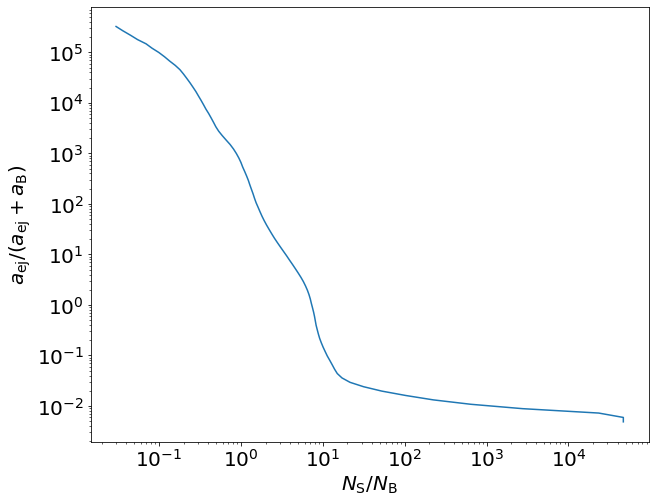

In [197]:
plt.figure(figsize=(10,8))
plt.loglog(Ns/Nb, aejarray)
# plt.axline(xy1=((Ns/Nb)[1], aejarray[0]), xy2=((Ns/Nb)[-1], aejarray[-10]), color='black')

plt.xlabel('$N_{\mathrm{S}}/N_{\mathrm{B}}$')
plt.ylabel('$a_{\mathrm{ej}}/(a_{\mathrm{ej}}+a_{\mathrm{B}})$')

325.6126

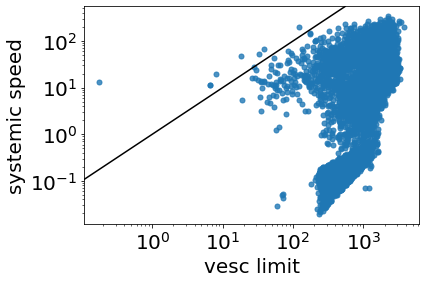

In [180]:
mutot = (BBHBound['   Mass(SN)   ']*BBHBound['   Mass(CP)   ']/(BBHBound['   Mass(SN)   ']+BBHBound['   Mass(CP)   ']))
vesclim = np.sqrt(7*G*mutot/BBHBound['SemiMajorAxis '] * (avgBHMass+1))

plt.scatter(vesclim, BBHBound['SystemicSpeed '], s=25, alpha=0.8)
plt.axline((0,0), slope=1, color='black')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('vesc limit')
plt.ylabel('systemic speed')

max(BBHUnbound['SystemicSpeed '])

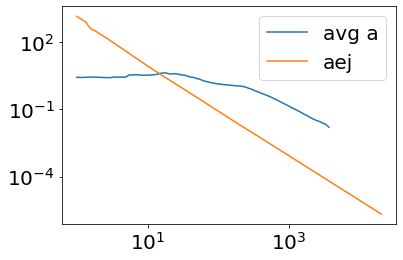

In [182]:
aejarray = np.asarray(aejarray)
plt.loglog(vesc_array, avgsemi*Rsol2AU, label='avg a')
plt.loglog(vesc_array, aejarray*Rsol2AU, label='aej')
plt.legend()